# Exploratory Analysis and Linear Regression

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.stats.diagnostic import het_white
import random
matplotlib.style.use('ggplot')

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
md_actor_producer = pd.read_csv("./data/md_actor_producer.csv")
print len(md_actor_producer)

1401


# Adding New Features

In [3]:
# Working with md_actor_producer

# movie_era == 1.0 if year >= 1999, movie_era == 0 if year < 1999
md_actor_producer['movie_era'] = (md_actor_producer['year']>=1999)*1.0

# Joining P and PG ratings
bool_list = (md_actor_producer['rating'] == 'G') | (md_actor_producer['rating'] == 'PG')
pgs = pd.Series(['PG']*len(md_actor_producer))
md_actor_producer['ratingPGG'] = pgs*bool_list + md_actor_producer['rating']*~bool_list

# Joining P, PG, PG-13 ratings
bool_list = (md_actor_producer['rating'] == 'G') | (md_actor_producer['rating'] == 'PG') | \
            (md_actor_producer['rating'] == 'PG-13')
pgs = pd.Series(['PG']*len(md_actor_producer))
md_actor_producer['ratingPG'] = pgs*bool_list + md_actor_producer['rating']*~bool_list

In [4]:
# Grouping genres to categories
def get_genre(s):
    if 'Comedy' in s:
        return 'Comedy+Romance'
    elif 'Action' in s:
        return 'Action+Horror'
    elif 'Drama' in s:
        return 'Drama'
    elif 'Horror' in s:
        return 'Action+Horror'
    elif 'Romance' in s:
        return 'Comedy+Romance'
    elif 'Sci-Fi':
        return 'Sci-Fi'
    else:
        return 'Uncategorized'

def get_genre2(s):
    if 'Comedy' in s:
        return 'Comedy+Romance+Drama'
    elif 'Action' in s:
        return 'Action+Horror+Sci-Fi'
    elif 'Drama' in s:
        return 'Comedy+Romance+Drama'
    elif 'Sci-Fi':
        return 'Action+Horror+Sci-Fi'
    else:
        return 'Uncategorized'
    
md_actor_producer['genre_adj'] = md_actor_producer['genre'].map(lambda s: get_genre(s))
md_actor_producer['genre2'] = md_actor_producer['genre_adj'].map(lambda s: get_genre2(s))

In [5]:
# adjusting for exp effect in theaters
md_actor_producer['theatersdiv1000'] = md_actor_producer.theaters/1000.0
md_actor_producer['theatersdiv1000exp'] = np.exp(md_actor_producer.theatersdiv1000)
# Printing range of theaters/1000 and exp(theaters/1000)
print max(md_actor_producer.theatersdiv1000)
print max(md_actor_producer.theatersdiv1000exp)
print min(md_actor_producer.theatersdiv1000)
print min(md_actor_producer.theatersdiv1000exp)

4.468
87.1821841644
0.005
1.00501252086


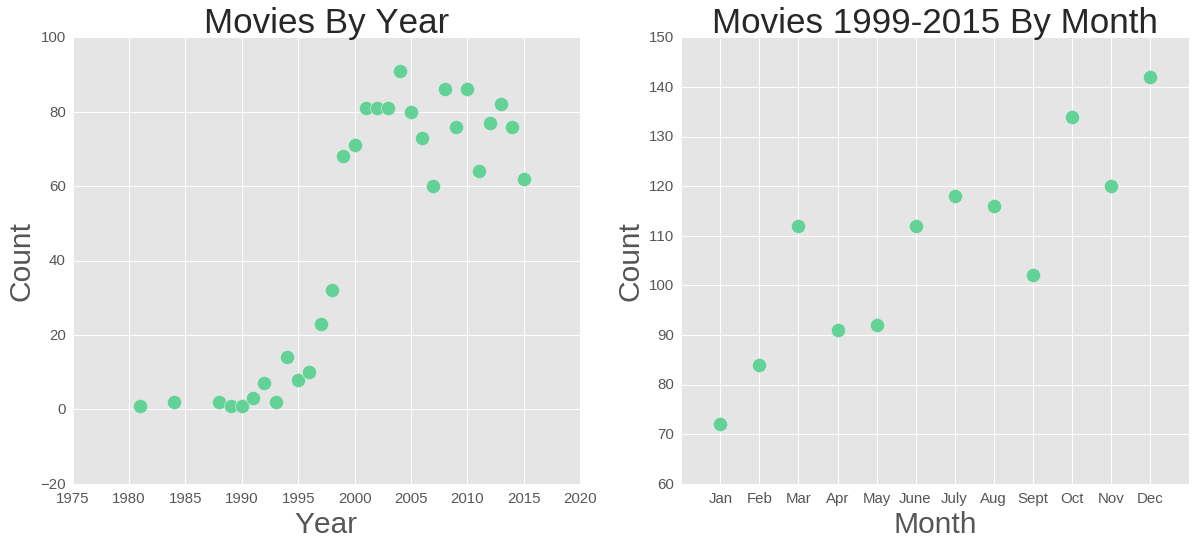

In [6]:
# Simple Analysis 

# BY RATING
# print md_actor_producer.rating.unique()
# print md_actor_producer.groupby("rating").mean().sort_values(by='total_gross', ascending=False)

# BY DIRECTOR
# data_director = md_actor_producer[ pd.notnull(md_actor_producer['director']) ]
# data_director_group = data_director.groupby('director').mean()
# data_director_sorted = data_director_group.sort_values(by='total_gross', ascending = False)

# BY YEAR
size_by_year_actor_prod = md_actor_producer.groupby("year").agg(['count']).reset_index()[['year','movie_title']]
size_by_month_actor_prod = md_actor_producer.groupby("month").agg(['count']).reset_index()[['month','movie_title']]
size_2000 = md_actor_producer[md_actor_producer['year'] >= 1999 ]
size_2000_by_month = size_2000.groupby("month").agg(['count']).reset_index()[['month','movie_title']]
months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
plt.close('all') 
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.scatter(size_by_year_actor_prod.year,size_by_year_actor_prod.movie_title,c='#63d297',s=200)
plt.xlabel('Year',fontsize=30)    
plt.ylabel('Count',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Movies By Year', fontsize=35)
plt.subplot(1,2,2)
plt.scatter(size_2000_by_month.month,size_2000_by_month.movie_title,c='#63d297',s=200)
plt.xlabel('Month',fontsize=30)    
plt.ylabel('Count',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(size_2000_by_month.month, months, rotation='horizontal')
plt.title('Movies 1999-2015 By Month',fontsize=35)
plt.xlim(0,13)
plt.savefig('./figs/actorproducer_count_vs_year+month.png') 

In [7]:
# Split the data into training and testing sets
random.seed(123)
train_valid, test = train_test_split(md_actor_producer[ md_actor_producer['movie_era'] == 1], test_size = 0.2)
train, validation = train_test_split(train_valid, test_size = 0.2)
print len(train)
print len(validation)
print len(test)

828
208
259


In [8]:
# Print correlations among selected features in the training set
md_selected = train_valid[['total_gross',
                   'movie_score','runtime',
                   'budget','theatersdiv1000exp',
                   'month','year',
                   'actors_score','producer_score']]
print md_selected.corr()

                    total_gross  movie_score   runtime    budget  \
total_gross            1.000000     0.287238  0.287079  0.621005   
movie_score            0.287238     1.000000  0.356348  0.118215   
runtime                0.287079     0.356348  1.000000  0.372858   
budget                 0.621005     0.118215  0.372858  1.000000   
theatersdiv1000exp     0.728850     0.070745  0.128096  0.685118   
month                  0.019018     0.217688  0.146927  0.012384   
year                   0.008175     0.040632  0.012128 -0.021234   
actors_score           0.328845     0.141443  0.192368  0.339131   
producer_score         0.475880     0.083140  0.154087  0.481012   

                    theatersdiv1000exp     month      year  actors_score  \
total_gross                   0.728850  0.019018  0.008175      0.328845   
movie_score                   0.070745  0.217688  0.040632      0.141443   
runtime                       0.128096  0.146927  0.012128      0.192368   
budget         

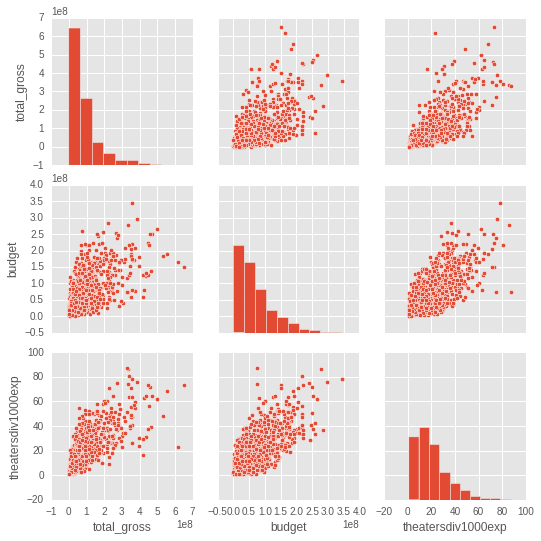

In [9]:
sns.pairplot(md_selected.ix[:,(0,3,4)])
plt.savefig('./figs/corr1.png') 

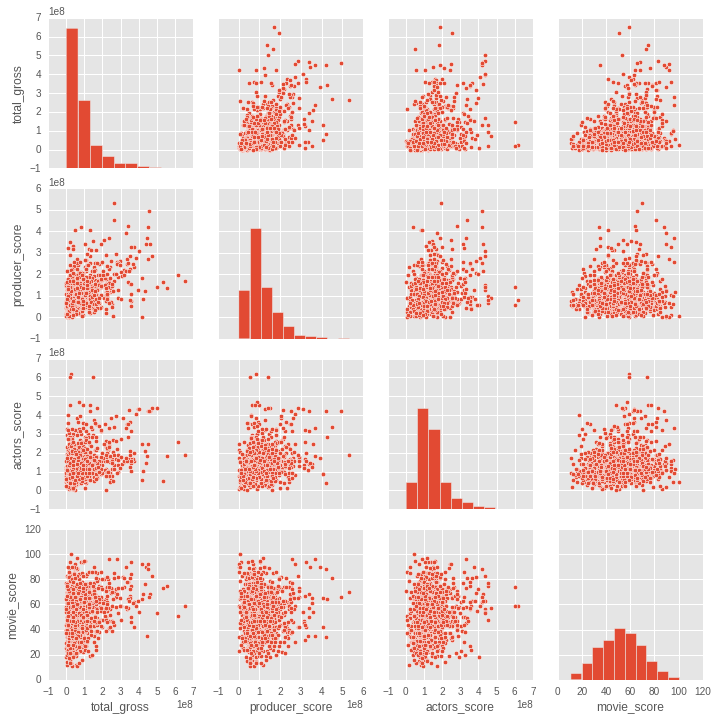

In [10]:
sns.pairplot(md_selected[['total_gross','producer_score','actors_score','movie_score']])
plt.savefig('./figs/corr2.png') 

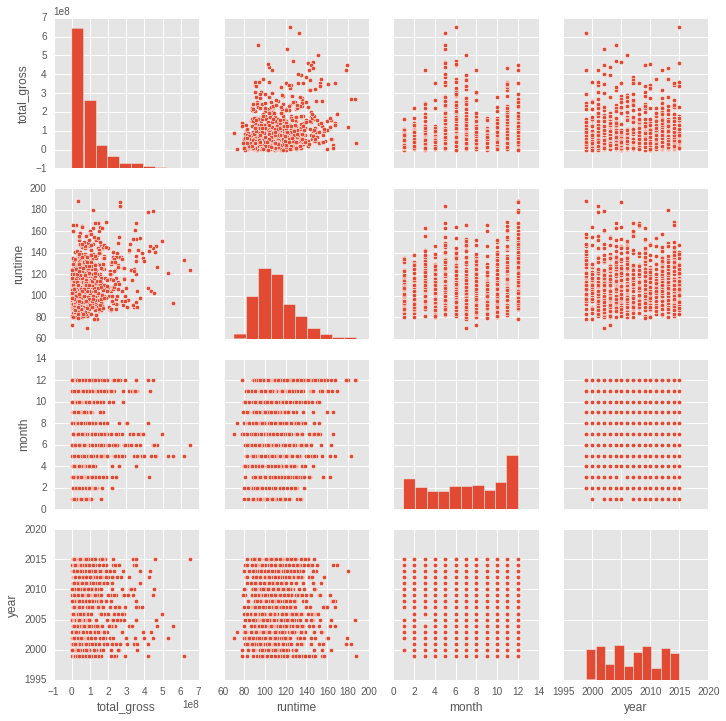

In [11]:
sns.pairplot(md_selected.ix[:,(0,2,5,6)])
plt.savefig('./figs/corr3.png') 

[ 4407598.1072061] [[  6.10211685e+09]]


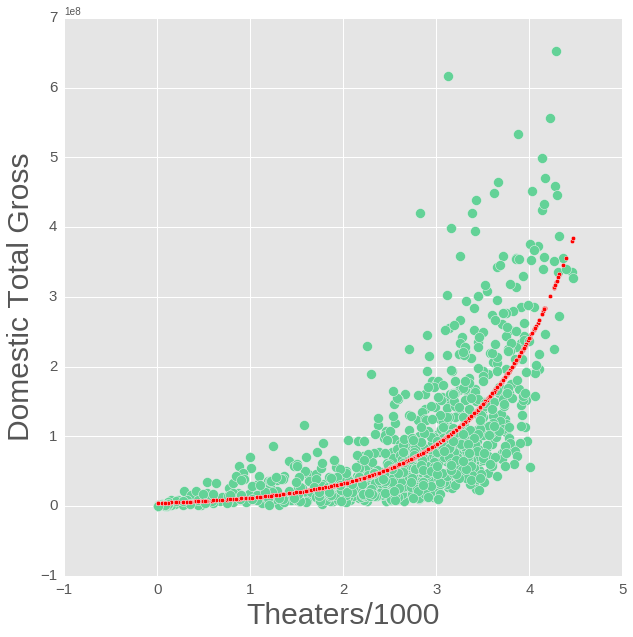

In [12]:
# Modeling Total Gross vs Number of Theaters
from scipy.optimize import curve_fit
def func(x,a):
    return a*np.exp(x)

x = train_valid.theatersdiv1000
y = train_valid.total_gross
popt, pcov = curve_fit(func, x, y)
print popt, pcov
plt.close('all')
plt.figure(figsize = (10,10))
plt.scatter(x,y,c='#63d297',s=100, label="Observed Data")
plt.scatter(x, func(x, *popt), c='red', label="Fitted Curve")
plt.xlabel('Theaters/1000',fontsize=30)    
plt.ylabel('Domestic Total Gross',fontsize=30) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('./figs/exptheaters.png') 

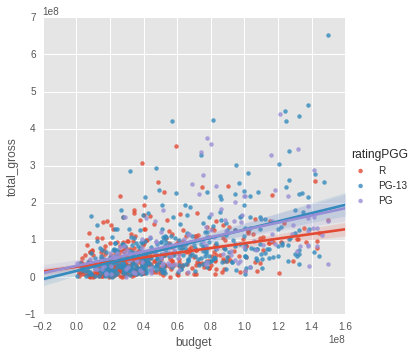

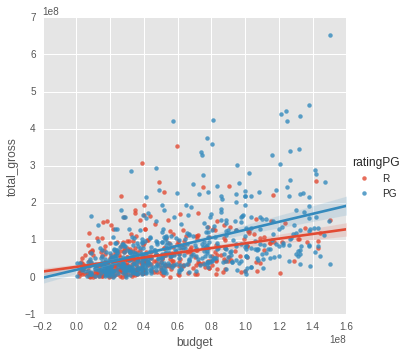

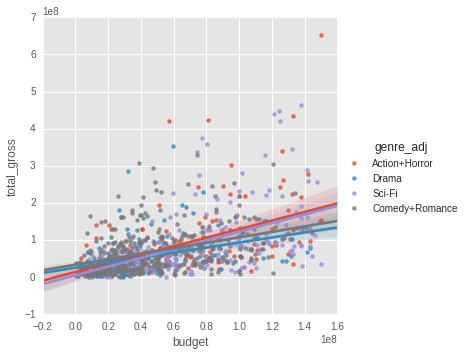

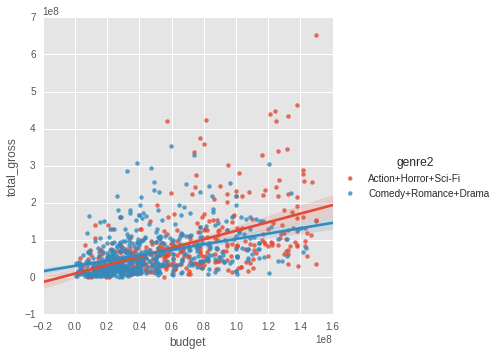

In [13]:
# Total gross vs budget by ratings and genre
plt.close('all')
plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="ratingPGG", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('./figs/gross_vs_budget_byratingPGG.png') 

plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="ratingPG", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('./figs/gross_vs_budget_byratingPG.png') 

plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="genre_adj", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('./figs/gross_vs_budget_bygenre.png') 

plt.figure(figsize = (10,10))  
sns.lmplot(x="budget", y="total_gross", hue="genre2", data=train_valid[train_valid.budget <= 1.5e+8])
plt.savefig('./figs/gross_vs_budget_bygenre2.png')

# Linear Regression: Comparing Models 

4.99181503358e+17 0.13
[  9.65096823e+07   5.73557641e+07   2.69456627e+05   3.91418719e+08
  -5.01294980e+06  -8.06762428e+07   4.86902462e+07   6.38312938e+07]


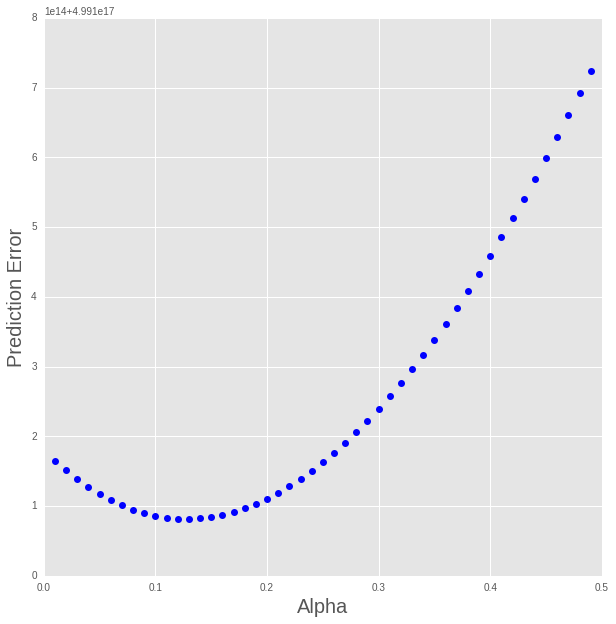

In [25]:
# Split the train+validation set into my_train and my_test sets
# Normalize the dataframe columns
random.seed(123)
my_train, my_test = train_test_split(md_selected, test_size = 0.2)
cols_to_norm = ['movie_score','runtime','budget','theatersdiv1000exp',\
                'month','year','actors_score','producer_score']
my_train[cols_to_norm] = my_train[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
my_test[cols_to_norm] = my_test[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
y = my_train['total_gross']
X = my_train.drop('total_gross',1)
kf = KFold(len(X), n_folds=5)
alphas = np.arange(0.01,0.5,0.01)
prediction_er = []
for alpha in alphas:
    sses = []
    for train_index, test_index in kf:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        #clf = Lasso(alpha=alpha)
        clf = Ridge(alpha=alpha)
        results = clf.fit(X_train, y_train) 
        predictions = results.predict(X_test)
        average = np.mean(y_test)
        sse = np.sum((predictions - y_test)**2.0)
        sses.append(sse)
    total = sum(sses)
    prediction_er.append(total/5.0)

plt.close('all')       
plt.figure(figsize = (10,10))    
plt.plot(alphas,prediction_er,'bo',lw=4)    
plt.xlabel('Alpha',fontsize=20)    
plt.ylabel('Prediction Error',fontsize=20)   
print min(prediction_er), alphas[prediction_er.index(min(prediction_er))]
#clf = Lasso(alpha = alphas[prediction_er.index(min(prediction_er))])
clf = Ridge(alpha = alphas[prediction_er.index(min(prediction_er))])
results = clf.fit(X, y) 
print results.coef_

##  All coeficients are important

# Building Models

In [15]:
def get_summary_noint(s, train, validation, k, drop_list=[]):
    y_train, X_train = dmatrices(s, data=train, return_type='dataframe')
    y_valid, X_valid = dmatrices(s, data=validation, return_type='dataframe')
    X_train = X_train.drop('Intercept',1)
    X_valid = X_valid.drop('Intercept',1)
    for item in drop_list:
        X_train = X_train.drop(item,1)
        X_valid = X_valid.drop(item,1)
    model = sm.OLS(y_train, X_train).fit()
    print model.summary()
    predictions = model.predict(X_valid)
    y_valid = np.array(y_valid.total_gross)
    rsq_noint = 1.0 - (np.mean((y_valid - predictions)**2))/(np.mean(y_valid**2))
    #http://stats.stackexchange.com/questions/26176/
    #removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo
    m = len(y_valid)*1.0 # number of points
    dfe = m - k
    dft = m 
    adj_rsq = 1 - ((np.mean((y_valid - predictions)**2))/dfe)/((np.mean(y_valid**2))/dft)
    print "R squared - no intercept: ", rsq_noint
    print "Adjusted R squared - no intercept: ", adj_rsq
     
def get_summary(s, train, validation, k, drop_list =[]):
    y_train, X_train = dmatrices(s, data=train, return_type='dataframe')
    y_valid, X_valid = dmatrices(s, data=validation, return_type='dataframe')
    for item in drop_list:
        X_train = X_train.drop(item,1)
        X_valid = X_valid.drop(item,1)
    model = sm.OLS(y_train, X_train).fit()
    print model.summary()
    predictions = model.predict(X_valid)
    y_valid = np.array(y_valid.total_gross)
    average = np.mean(y_valid)
    sse = np.sum((predictions - y_valid)**2.0)
    tss = np.sum((average - y_valid)**2.0)
    rsq = 1.0 - sse/tss
    m = len(y_valid)*1.0 # number of points
    dfe = m - k - 1
    dft = m - 1
    adj_rsq = 1 - (sse/dfe)/(tss/dft)
    print "R squared: ", rsq
    print "Adjusted R squared: ", adj_rsq

In [16]:
get_summary_noint('total_gross ~ theatersdiv1000exp', train, validation, 1.0)

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     2513.
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          6.55e-253
Time:                        23:37:26   Log-Likelihood:                -16061.
No. Observations:                 828   AIC:                         3.212e+04
Df Residuals:                     827   BIC:                         3.213e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
theatersdiv1000exp  4.441e+06   8.86

In [17]:
get_summary_noint('total_gross ~ budget', train, validation, 1.0)
get_summary('total_gross ~ budget', train, validation, 1.0)

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1782.
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          1.59e-208
Time:                        23:37:26   Log-Likelihood:                -16163.
No. Observations:                 828   AIC:                         3.233e+04
Df Residuals:                     827   BIC:                         3.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
budget         1.2026      0.028     42.214      0.0

In [18]:
get_summary_noint('total_gross ~ budget + producer_score', train, validation, 2.0)
get_summary('total_gross ~ budget + producer_score', train, validation, 2.0)

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     988.5
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          7.06e-220
Time:                        23:37:26   Log-Likelihood:                -16133.
No. Observations:                 828   AIC:                         3.227e+04
Df Residuals:                     826   BIC:                         3.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
budget             0.8991      0.047     19.

In [19]:
get_summary_noint('total_gross ~ budget + producer_score + actors_score', train, validation, 3.0)
get_summary('total_gross ~ budget + producer_score + actors_score', train, validation, 3.0)

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     667.1
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          4.95e-220
Time:                        23:37:26   Log-Likelihood:                -16129.
No. Observations:                 828   AIC:                         3.226e+04
Df Residuals:                     825   BIC:                         3.228e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
budget             0.8444      0.051     16.

In [20]:
get_summary_noint('total_gross ~ budget + producer_score + actors_score + movie_score', train, validation, 4.0)
get_summary('total_gross ~ budget + producer_score + actors_score + movie_score', train, validation, 4.0)

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     507.8
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          1.26e-220
Time:                        23:37:26   Log-Likelihood:                -16124.
No. Observations:                 828   AIC:                         3.226e+04
Df Residuals:                     824   BIC:                         3.228e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
budget             0.8221      0.051     16.

In [21]:
get_summary_noint('total_gross ~ producer_score + actors_score + budget*ratingPG', 
                  train, validation, 4.0, ['ratingPG[T.R]'])
get_summary('total_gross ~ producer_score + actors_score + budget*ratingPG', 
            train, validation, 4.0, ['ratingPG[T.R]'])

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     517.4
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          5.12e-223
Time:                        23:37:26   Log-Likelihood:                -16119.
No. Observations:                 828   AIC:                         3.225e+04
Df Residuals:                     824   BIC:                         3.226e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
producer_score           0.1998 

In [22]:
get_summary_noint('total_gross ~ producer_score + actors_score + budget*ratingPG + budget*genre2', 
                  train, validation, 5.0, ['ratingPG[T.R]','genre2[T.Comedy+Romance+Drama]'])
get_summary('total_gross ~ producer_score + actors_score + budget*ratingPG + budget*genre2', 
            train, validation, 5.0, ['ratingPG[T.R]','genre2[T.Comedy+Romance+Drama]'])

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     418.4
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          3.65e-223
Time:                        23:37:26   Log-Likelihood:                -16115.
No. Observations:                 828   AIC:                         3.224e+04
Df Residuals:                     823   BIC:                         3.226e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

In [23]:
get_summary_noint('total_gross ~ movie_score + runtime + year + theatersdiv1000exp', 
                  train, validation, 4.0)
get_summary('total_gross ~ movie_score + runtime + year + theatersdiv1000exp', 
            train, validation, 4.0)

                            OLS Regression Results                            
Dep. Variable:            total_gross   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     792.6
Date:                Fri, 22 Apr 2016   Prob (F-statistic):          1.22e-280
Time:                        23:37:26   Log-Likelihood:                -15985.
No. Observations:                 828   AIC:                         3.198e+04
Df Residuals:                     824   BIC:                         3.200e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
movie_score         1.029e+06   1.26